In [68]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import accuracy_score

In [70]:
class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.1, num_epochs=10000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def set_hyperparameters(self, learning_rate, num_epochs):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, X, y):
        z = np.dot(X, self.weights.T) + self.bias
        y_pred = self.softmax(z)
        m = y_pred.shape[0]
        return -np.sum(np.log(y_pred) * y)/m

    def gradient_descent(self, X, y):
        m = X.shape[0]
        for epoch in range(self.num_epochs):
            z = np.dot(X, self.weights.T) + self.bias
            y_pred = self.softmax(z)
            dw = np.dot((y_pred - y).T, X)/m
            db = np.sum(y_pred - y, axis=0)/m
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            # print(loss)

    def fit(self, X, y):
        num_classes = y.shape[1]
        num_features = X.shape[1]
        self.weights = np.zeros((num_classes, num_features))
        self.bias = np.zeros(num_classes)
        self.gradient_descent(X, y)

    def predict(self, X):
        z = np.dot(X, self.weights.T) + self.bias
        max_values = np.max(z, axis=1, keepdims=True)
        y_pred = (z == max_values).astype(int)
        return y_pred
    
    def predict_proba(self,X):
        z = np.dot(X, self.weights.T) + self.bias
        return z

In [71]:
class MLPClassifier(object):
    def __init__(self, inputLayerSize=2, hiddenLayers=1, hiddenLayerSize=3, outputLayerSize=1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="gd"):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayers = hiddenLayers
        self.hiddenLayerSize = hiddenLayerSize
        self.activationFunction=acivationFunction
        self.number_epoch=number_epoch
        self.learning_rate=learning_rate
        self.optimizer=optimizer

    def initialize(self):
        self.weights=[]
        self.biases=[]
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize))
        self.biases.append(np.random.randn(self.hiddenLayerSize))
        for i in range(self.hiddenLayers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize, self.hiddenLayerSize))
            self.biases.append(np.random.randn(self.hiddenLayerSize))
        self.weights.append(np.random.randn(self.hiddenLayerSize, self.outputLayerSize))
        self.biases.append(np.random.randn(self.outputLayerSize))

    def fit(self,X,y):
        if self.optimizer=="gd":
            self.gd(X,y)
        if self.optimizer=="mini_gd":
            self.mini_gd(X,y)
        if self.optimizer=="sgd":
            self.sgd(X,y)

    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def activation(self,z):
        if(self.activationFunction=='sigmoid'):
            return 1 / (1 + np.exp(-z))
        if(self.activationFunction=='relu'):
            return np.maximum(0, z)
        if(self.activationFunction=='tanh'):
            return np.tanh(z)
    
    def activationPrime(self,z):    
        if(self.activationFunction=='sigmoid'):
            return np.exp(-z)/((1 + np.exp(-z))**2)
        if(self.activationFunction=='relu'):
            return (z > 0).astype(int)
        if(self.activationFunction=='tanh'):
            return 1 - np.tanh(z) ** 2

    def forward(self, X):
        self.z=[]
        self.a=[]
        self.z.append(np.dot(X,self.weights[0])+self.biases[0])
        self.a.append(self.activation(self.z[0]))
        for i in range(1,self.hiddenLayers):
            self.z.append(np.dot(self.a[i-1],self.weights[i])+self.biases[i])
            self.a.append(self.activation(self.z[i]))
        self.z.append(np.dot(self.a[self.hiddenLayers-1],self.weights[self.hiddenLayers])+self.biases[self.hiddenLayers])
        self.a.append(self.softmax(self.z[self.hiddenLayers]))
        yHat=self.a[self.hiddenLayers]
        return yHat
    
    def predict(self, X):
        yHat=self.forward(X)
        max_values = np.max(yHat, axis=1, keepdims=True)
        y_pred = (yHat == max_values).astype(int)
        return y_pred
    
    def predict_proba(self,X):
        yHat=self.forward(X)
        return yHat

    def backward(self,X,y):
        m=len(X)
        yHat=self.forward(X)
        self.delta=[]
        self.gradient_weight=[]
        self.gradient_bias=[]
        self.delta.append(-(y-yHat)/m)
        self.gradient_weight.append(np.dot(self.a[self.hiddenLayers-1].T,self.delta[-1]))
        self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        for i in range(self.hiddenLayers-1,0,-1):
            delta_i=np.dot(self.delta[-1],self.weights[i+1].T)*self.activationPrime(self.z[i])/m
            self.delta.append(delta_i)
            self.gradient_weight.append(np.dot(self.a[i-1].T,delta_i))
            self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        delta_i=np.dot(self.delta[-1],self.weights[1].T)*self.activationPrime(self.z[0])/m
        self.delta.append(delta_i)
        self.gradient_weight.append(np.dot(X.T,delta_i))
        self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        self.gradient_weight.reverse()
        self.gradient_bias.reverse()

    def loss(self, y_pred, y_true):
        m=len(y_pred)
        return -np.sum(np.log(y_pred) * y_true)/m

    def gd(self,X,y):
        self.initialize()
        for i in range (self.number_epoch):
            # print(self.loss(self.forward(X),y))
            self.backward(X,y)
            for j in range(len(self.weights)):
                self.weights[j]-=self.learning_rate*self.gradient_weight[j]
                self.biases[j]-=self.learning_rate*self.gradient_bias[j]

    def mini_gd(self,X,y):
        self.initialize()
        batch_size=32
        batches=len(X)//batch_size
        for epoch in range(self.number_epoch):
            for i in range(0,batches,batch_size):
                self.backward(X[i:i+batch_size],y[i:i+batch_size])
                for k in range(len(self.weights)):
                    self.weights[k]-=self.learning_rate*self.gradient_weight[k]
                    self.biases[k]-=self.learning_rate*self.gradient_bias[k]
            # print(self.loss(self.forward(X),y))

    def sgd(self,X,y):
        self.initialize()
        for j in range(self.number_epoch):
            for i in range(len(X)):
                self.backward(X[i:i+1],y[i:i+1])
                for k in range(len(self.weights)):
                    self.weights[k]-=self.learning_rate*self.gradient_weight[k]
                    self.biases[k]-=self.learning_rate*self.gradient_bias[k]
            # print(self.loss(self.forward(X),y))


### Data Preprocessing

In [72]:
wine_data = pd.read_csv('WineQT.csv')

X= wine_data.drop(columns=['quality','Id'])
y=wine_data['quality']
y = pd.get_dummies(y, columns=['quality']).astype(int)
X=X.to_numpy()
y=y.to_numpy()

X_train_cl, X_temp_cl, y_train_cl, y_temp_cl = train_test_split(X, y, test_size=0.2)
X_val_cl, X_test_cl, y_val_cl, y_test_cl = train_test_split(X_temp_cl, y_temp_cl, test_size=0.5)


scaler = StandardScaler()
X_train_cl = scaler.fit_transform(X_train_cl)
X_val_cl = scaler.transform(X_val_cl)
X_test_cl = scaler.transform(X_test_cl)

In [73]:
model = MultinomialLogisticRegression(0.01,1000)
model.fit(X_train_cl, y_train_cl)

y_pred = model.predict(X_test_cl)
print('Loss :',model.cross_entropy_loss(X_train_cl,y_train_cl))
print('Accuracy :',accuracy_score(y_test_cl, y_pred))

Loss : 1.0190570608178335
Accuracy : 0.6173913043478261


In [74]:
model = MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")
model.fit(X_train_cl,y_train_cl)

y_pred=model.predict(X_train_cl)
print(accuracy_score(y_train_cl, y_pred))

y_pred=model.predict(X_test_cl)
print(accuracy_score(y_test_cl, y_pred))

0.6214442013129103
0.6434782608695652


In [75]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy',max_depth=30)
clf.fit(X_train_cl, y_train_cl)
y_pred = clf.predict(X_test_cl)

accuracy = accuracy_score(y_test_cl, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6260869565217392


### Stacking and Blending for Classification

In [76]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

class StackingClassifier:
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def stacking(self, X, y):
        y_labels = np.argmax(y, axis=1)
        train_pred = [np.zeros(len(y_labels)) for _ in self.base_models]
        test_pred = list()
        for i, model in enumerate(self.base_models):
            skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True)
            for train_idx, valid_idx in skf.split(X, y_labels):
                X_train, X_valid = X[train_idx], X[valid_idx]
                y_train, y_valid = y_labels[train_idx], y_labels[valid_idx]
                unique_labels = np.unique(y_train)
                y_train = np.eye(len(unique_labels))[y_train].astype(int)
                model.fit(X_train, y_train)
                y_pred=model.predict(X_valid)
                y_pred = np.argmax(y_pred, axis=1)
                train_pred[i][valid_idx] = y_pred

            y_pred_test=model.predict(X_test_cl)
            y_pred_test = np.argmax(y_pred_test, axis=1)
            test_pred.append(y_pred_test)

        meta_train_features=np.column_stack(train_pred)
        meta_test_features=np.column_stack(test_pred)

        self.meta_model.fit(meta_train_features,y)
        y_pred=self.meta_model.predict(meta_test_features)
        return accuracy_score(y_test_cl,y_pred)

    def blending(self, X, y):
        train_pred = list()
        test_pred = list()
        for model in self.base_models:
            model.fit(X, y)
            y_pred=model.predict(X_val_cl)
            train_pred.append(y_pred)

            y_pred_test=model.predict(X_test_cl)
            test_pred.append(y_pred_test)

        meta_train_features=np.column_stack(train_pred)
        meta_test_features=np.column_stack(test_pred)

        self.meta_model.fit(meta_train_features,y_val_cl)
        y_pred=self.meta_model.predict(meta_test_features)
        return accuracy_score(y_test_cl,y_pred)

In [77]:
base_models = [MultinomialLogisticRegression(0.01,1000),DecisionTreeClassifier(criterion='gini',max_depth=20),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")]
meta_model = MultinomialLogisticRegression(0.01,1000)
stacking_model = StackingClassifier(base_models, meta_model)
stacking_model.stacking(X_train_cl, y_train_cl)

/home/ishitbansal/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/ishitbansal/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/ishitbansal/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


0.6260869565217392

In [78]:
base_models = [MultinomialLogisticRegression(0.01,1000),DecisionTreeClassifier(criterion='gini',max_depth=20),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")]
meta_model = MultinomialLogisticRegression(0.01,1000)
stacking_model = StackingClassifier(base_models, meta_model)
stacking_model.blending(X_train_cl, y_train_cl)

0.6521739130434783

In [79]:
base_models = [MultinomialLogisticRegression(0.01,1000),DecisionTreeClassifier(criterion='gini',max_depth=20),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")]
meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
stacking_model = StackingClassifier(base_models, meta_model)
stacking_model.stacking(X_train_cl, y_train_cl)

/home/ishitbansal/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/ishitbansal/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/ishitbansal/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


0.591304347826087

In [80]:
base_models = [MultinomialLogisticRegression(0.01,1000),DecisionTreeClassifier(),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")]
meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
stacking_model = StackingClassifier(base_models, meta_model)
stacking_model.blending(X_train_cl, y_train_cl)

0.5478260869565217

### Hyperparameter Tuning for StackingClassifier

Assumed different combinations as base_models for hyperparameter tuning

In [81]:
models_1 = [MultinomialLogisticRegression(0.01,1000),DecisionTreeClassifier(criterion='gini',max_depth=20),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")]
models_2 = [MultinomialLogisticRegression(0.01,1000),DecisionTreeClassifier(criterion='gini',max_depth=20),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")]
models_3 = [MultinomialLogisticRegression(0.01,1000),DecisionTreeClassifier(criterion='gini',max_depth=20),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")]

best_hyperparameters_cl=tuple()
best_accuracy_cl=0
for model_1 in models_1:
    for model_2 in models_2:
        for model_3 in models_3:
            base_models = [model_1,model_2,model_3]
            meta_model = MultinomialLogisticRegression(0.01,1000)
            stacking_model = StackingClassifier(base_models, meta_model)
            accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
            if(accuracy>best_accuracy_cl):
                best_hyperparameters_reg=('base_model :',model_1,model_2,model_3,'meta_model :',meta_model,'stacking_methodology : Stacking')
                best_accuracy_cl=accuracy

            base_models = [model_1,model_2,model_3]
            meta_model = MultinomialLogisticRegression(0.01,1000)
            stacking_model = StackingClassifier(base_models, meta_model)
            accuracy=stacking_model.blending(X_train_cl, y_train_cl)
            if(accuracy>best_accuracy_cl):
                best_hyperparameters_reg=('base_model :',model_1,model_2,model_3,'meta_model :',meta_model,'stacking_methodology : Blending')
                best_accuracy_cl=accuracy

            base_models = [model_1,model_2,model_3]
            meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
            stacking_model = StackingClassifier(base_models, meta_model)
            accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
            if(accuracy>best_accuracy_cl):
                best_hyperparameters_reg=('base_model :',model_1,model_2,model_3,'meta_model :',meta_model,'stacking_methodology : Stacking')
                best_accuracy_cl=accuracy

            base_models = [model_1,model_2,model_3]
            meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
            stacking_model = StackingClassifier(base_models, meta_model)
            a=stacking_model.blending(X_train_cl, y_train_cl)
            if(accuracy>best_accuracy_cl):
                best_hyperparameters_reg=('base_model :',model_1,model_2,model_3,'meta_model :',meta_model,'stacking_methodology : Stacking')
                best_accuracy_cl=accuracy

### Best Hyperparameters for StackingClassifier

In [82]:
print('Best Hyperparameters :',best_hyperparameters_cl)

Best Hyperparameters : ('base_model :', <__main__.MLPClassifier object at 0x7f34d8df5900>, DecisionTreeClassifier(max_depth=20), <__main__.MLPClassifier object at 0x7f34d8df4af0>, 'meta_model :', <__main__.MLPClassifier object at 0x7f34d8df4820>, 'stacking_methodology : Blending')


From above, best hyperparameters :- <br>
base_models : LogisticRegression,DecisionTreeClassifier,MLPClassifier <br>
meta_model : LogisticRegression <br>
stacking_methodology : Blending

## Regression

In [83]:
class MultipleLinearRegression:
    def __init__(self, learning_rate=0.01, num_epochs=1000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.coefficients = np.zeros(num_features)
        self.intercept = 0
        
        for i in range(self.num_epochs):
            y_pred = np.dot(X, self.coefficients) + self.intercept
            dw = (1/num_samples) * np.dot(X.T, (y_pred - y))
            db = (1/num_samples) * np.sum(y_pred - y)
            self.coefficients -= self.learning_rate * dw
            self.intercept -= self.learning_rate * db
            mse = self.mean_squared_error(y, y_pred)
            # print(mse)

    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def predict(self, X):
        return np.dot(X, self.coefficients) + self.intercept

In [84]:
class MLPRegressor(object):
    def __init__(self, inputLayerSize=2, hiddenLayers=1, hiddenLayerSize=3, outputLayerSize=1,acivationFunction="sigmoid",number_epoch=10000,learning_rate=0.3,optimizer="gd"):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayers = hiddenLayers
        self.hiddenLayerSize = hiddenLayerSize
        self.activationFunction=acivationFunction
        self.number_epoch=number_epoch
        self.learning_rate=learning_rate
        self.optimizer=optimizer

    def initialize(self):
        self.weights=[]
        self.biases=[]
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize))
        self.biases.append(np.random.randn(self.hiddenLayerSize))
        for i in range(self.hiddenLayers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize, self.hiddenLayerSize))
            self.biases.append(np.random.randn(self.hiddenLayerSize))
        self.weights.append(np.random.randn(self.hiddenLayerSize, self.outputLayerSize))
        self.biases.append(np.random.randn(self.outputLayerSize))

    def fit(self,X,y):
        y=y.reshape((len(y),1))
        if self.optimizer=="gd":
            self.gd(X,y)
        if self.optimizer=="mini_gd":
            self.mini_gd(X,y)
        if self.optimizer=="sgd":
            self.sgd(X,y)
    
    def activation(self,z):
        if(self.activationFunction=='sigmoid'):
            return 1 / (1 + np.exp(-z))
        if(self.activationFunction=='relu'):
            return np.maximum(0, z)
        if(self.activationFunction=='tanh'):
            return np.tanh(z)
    
    def activationPrime(self,z):    
        if(self.activationFunction=='sigmoid'):
            return np.exp(-z)/((1 + np.exp(-z))**2)
        if(self.activationFunction=='relu'):
            return (z > 0).astype(int)
        if(self.activationFunction=='tanh'):
            return 1 - np.tanh(z) ** 2

    def forward(self, X):
        self.z=[]
        self.a=[]
        self.z.append(np.dot(X,self.weights[0])+self.biases[0])
        self.a.append(self.activation(self.z[0]))
        for i in range(1,self.hiddenLayers):
            self.z.append(np.dot(self.a[i-1],self.weights[i])+self.biases[i])
            self.a.append(self.activation(self.z[i]))
        self.z.append(np.dot(self.a[self.hiddenLayers-1],self.weights[self.hiddenLayers])+self.biases[self.hiddenLayers])
        self.a.append(self.z[self.hiddenLayers])
        yHat=self.a[self.hiddenLayers]
        return yHat
    
    def predict(self, X):
        yHat=self.forward(X)
        return yHat

    def backward(self,X,y):
        m=len(X)
        yHat=self.forward(X)
        self.delta=[]
        self.gradient_weight=[]
        self.gradient_bias=[]
        self.delta.append(-(y-yHat)/m)
        self.gradient_weight.append(np.dot(self.a[self.hiddenLayers-1].T,self.delta[-1]))
        self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        for i in range(self.hiddenLayers-1,0,-1):
            delta_i=np.dot(self.delta[-1],self.weights[i+1].T)*self.activationPrime(self.z[i])/m
            self.delta.append(delta_i)
            self.gradient_weight.append(np.dot(self.a[i-1].T,delta_i))
            self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        delta_i=np.dot(self.delta[-1],self.weights[1].T)*self.activationPrime(self.z[0])/m
        self.delta.append(delta_i)
        self.gradient_weight.append(np.dot(X.T,delta_i))
        self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        self.gradient_weight.reverse()
        self.gradient_bias.reverse()

    def loss(self, y_pred, y_true):
        m=len(y_pred)
        return 0.5*np.sum((y_true-y_pred)**2)

    def gd(self,X,y):
        self.initialize()
        for i in range (self.number_epoch):
            # print(self.loss(self.forward(X),y))
            self.backward(X,y)
            for j in range(len(self.weights)):
                self.weights[j]-=self.learning_rate*self.gradient_weight[j]
                self.biases[j]-=self.learning_rate*self.gradient_bias[j]

    def sgd(self,X,y):
        self.initialize()
        for j in range(self.number_epoch):
            for i in range(len(X)):
                self.backward(X[i:i+1],y[i:i+1])
                for k in range(len(self.weights)):
                    self.weights[k]-=self.learning_rate*self.gradient_weight[k]
                    self.biases[k]-=self.learning_rate*self.gradient_bias[k]
            # print(self.loss(self.forward(X),y))

    def mini_gd(self,X,y):
        self.initialize()
        batch_size=32
        batches=len(X)//batch_size
        for epoch in range(self.number_epoch):
            for i in range(0,batches,batch_size):
                self.backward(X[i:i+batch_size],y[i:i+batch_size])
                for k in range(len(self.weights)):
                    self.weights[k]-=self.learning_rate*self.gradient_weight[k]
                    self.biases[k]-=self.learning_rate*self.gradient_bias[k]
            # print(self.loss(self.forward(X),y))
    

### Data Preprocessing

In [85]:
housing_data = pd.read_csv('HousingData.csv')

housing_data.fillna(housing_data.mean(), inplace=True)

X= housing_data.drop(columns=['MEDV'])
y=housing_data['MEDV']
X=X.to_numpy()
y=y.to_numpy()

# y=y.reshape((len(y),1))

X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(X, y, test_size=0.2)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(X_temp_reg, y_temp_reg, test_size=0.5)

scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_val_reg = scaler.transform(X_val_reg)
X_test_reg = scaler.transform(X_test_reg)

In [86]:
model = MultipleLinearRegression(0.1,1000)
model.fit(X_train_reg, y_train_reg)
y_pred=model.predict(X_test_reg)
print(r2_score(y_test_reg,y_pred))

0.7723387966272751


In [87]:
model = MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")
model.fit(X_train_reg,y_train_reg)
y_pred=model.forward(X_test_reg)
print(r2_score(y_test_reg,y_pred))
print(mean_squared_error(y_test_reg,y_pred))

0.8115875549195148
18.23327427407508


In [88]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(X_train_reg, y_train_reg)
y_pred = regressor.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred)
print(f"Mean Squared Error: {mse}")
print(r2_score(y_test_reg,y_pred))

Mean Squared Error: 46.32392156862745
0.5213145375171808


### Stacking and Blending for Regression

In [89]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import KFold

class StackingRegressor:
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def stacking(self, X, y):
        train_pred = [np.zeros(len(y)) for _ in self.base_models]
        test_pred = list()
        for i, model in enumerate(self.base_models):
            kf = KFold(n_splits=4,shuffle=True)
            for train_idx, valid_idx in kf.split(X, y):
                X_train, X_valid = X[train_idx], X[valid_idx]
                y_train, y_valid = y[train_idx], y[valid_idx]
                model.fit(X_train, y_train)
                y_pred=model.predict(X_valid)
                y_pred = y_pred.reshape(y_pred.shape[0])
                train_pred[i][valid_idx] = y_pred

            y_pred_test=model.predict(X_test_reg)
            test_pred.append(y_pred_test)

        meta_train_features=np.column_stack(train_pred)
        meta_test_features=np.column_stack(test_pred)
        self.meta_model.fit(meta_train_features,y)
        y_pred=self.meta_model.predict(meta_test_features)
        return r2_score  (y_test_reg,y_pred)

    def blending(self, X, y):
        train_pred = list()
        test_pred = list()
        for model in self.base_models:
            model.fit(X, y)
            y_pred=model.predict(X_val_reg)
            train_pred.append(y_pred)
            y_pred_test=model.predict(X_test_reg)
            test_pred.append(y_pred_test)

        meta_train_features=np.column_stack(train_pred)
        meta_test_features=np.column_stack(test_pred)
        self.meta_model.fit(meta_train_features,y_val_reg)
        y_pred=self.meta_model.predict(meta_test_features)
        return r2_score(y_test_reg,y_pred)

In [90]:
base_models = [MultipleLinearRegression(0.001,10000),DecisionTreeRegressor(criterion='squared_error',max_depth=20),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")]
meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.stacking(X_train_reg, y_train_reg)
print(r2)

0.7183752638185625


In [91]:
base_models = [MultipleLinearRegression(0.001,10000),DecisionTreeRegressor(criterion='squared_error',max_depth=20),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")]
meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.blending(X_train_reg, y_train_reg)
print(r2)

0.5346122564371254


In [92]:
base_models = [MultipleLinearRegression(0.001,10000),DecisionTreeRegressor(criterion='squared_error',max_depth=20),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")]
meta_model = MultipleLinearRegression(0.001,10000)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.stacking(X_train_reg, y_train_reg)
print(r2)

0.8662700454521537


In [93]:
base_models = [MultipleLinearRegression(0.001,10000),DecisionTreeRegressor(criterion='squared_error',max_depth=20),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")]
meta_model = MultipleLinearRegression(0.001,10000)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.blending(X_train_reg, y_train_reg)
print(r2)

0.8450040047599089


### Hyperparameter Tuning for StackingRegressor

Assumed different combinations as base_models for hyperparameter tuning

In [94]:
models_1 = [MultipleLinearRegression(0.001,10000),DecisionTreeRegressor(criterion='squared_error',max_depth=20),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")]
models_2 = [MultipleLinearRegression(0.001,10000),DecisionTreeRegressor(criterion='squared_error',max_depth=20),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")]
models_3 = [MultipleLinearRegression(0.001,10000),DecisionTreeRegressor(criterion='squared_error',max_depth=20),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")]

best_hyperparameters_reg=tuple()
best_r2_reg=0
for model_1 in models_1:
    for model_2 in models_2:
        for model_3 in models_3:
            base_models = [model_1,model_2,model_3]
            meta_model = MultipleLinearRegression(0.001,10000)
            stacking_model = StackingRegressor(base_models, meta_model)
            r2=stacking_model.stacking(X_train_reg, y_train_reg)
            if(r2>best_r2_reg):
                best_hyperparameters_reg=('base_model :',model_1,model_2,model_3,'meta_model :',meta_model,'stacking_methodology : Stacking')
                best_r2_reg=r2

            base_models = [model_1,model_2,model_3]
            meta_model = MultipleLinearRegression(0.001,10000)
            stacking_model = StackingRegressor(base_models, meta_model)
            r2=stacking_model.blending(X_train_reg, y_train_reg)
            if(r2>best_r2_reg):
                best_hyperparameters_reg=('base_model :',model_1,model_2,model_3,'meta_model :',meta_model,'stacking_methodology : Blending')
                best_r2_reg=r2

            base_models = [model_1,model_2,model_3]
            meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
            stacking_model = StackingRegressor(base_models, meta_model)
            r2=stacking_model.stacking(X_train_reg, y_train_reg)
            if(r2>best_r2_reg):
                best_hyperparameters_reg=('base_model :',model_1,model_2,model_3,'meta_model :',meta_model,'stacking_methodology : Stacking')
                best_r2_reg=r2

            base_models = [model_1,model_2,model_3]
            meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
            stacking_model = StackingRegressor(base_models, meta_model)
            r2=stacking_model.blending(X_train_reg, y_train_reg)
            if(r2>best_r2_reg):
                best_hyperparameters_reg=('base_model :',model_1,model_2,model_3,'meta_model :',meta_model,'stacking_methodology : Blending')
                best_r2_reg=r2

### Best Hyperparameters for StackingRegressor

In [95]:
print('Best Hyperparameters :',best_hyperparameters_reg)

Best Hyperparameters : ('base_model :', <__main__.MultipleLinearRegression object at 0x7f34d8e25d80>, DecisionTreeRegressor(max_depth=20), <__main__.MLPRegressor object at 0x7f34d8e278e0>, 'meta_model :', <__main__.MultipleLinearRegression object at 0x7f34d8e27d60>, 'stacking_methodology : Blending')


From above, best hyperparameters :- <br>
base_models : LinearRegression,DecisionTreeRegressor,MLPRegressor <br>
meta_model : LinearRegression <br>
stacking_methodology : Blending

### Comparing the accuracies and the training time of the best-performing models of Bagging and Stacking ensembles of each Base Estimator Model class.

In [8]:
import time
base_models = [MultinomialLogisticRegression(0.01,1000),MultinomialLogisticRegression(0.01,1000),MultinomialLogisticRegression(0.01,1000)]
best_accuracy_lg = 0
training_time_cl_lg = 0
meta_model = MultinomialLogisticRegression(0.01,1000)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_lg):
    best_accuracy_lg=accuracy
    training_time_cl_lg=end-start

meta_model = MultinomialLogisticRegression(0.01,1000)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.blending(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_lg):
    best_accuracy_lg=accuracy
    training_time_cl_lg=end-start

meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_lg):
    best_accuracy_lg=accuracy
    training_time_cl_lg=end-start

meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_lg):
    best_accuracy_lg=accuracy
    training_time_cl_lg=end-start

In [9]:
import time
base_models = [DecisionTreeClassifier(criterion='gini',max_depth=20),DecisionTreeClassifier(criterion='gini',max_depth=20),DecisionTreeClassifier(criterion='gini',max_depth=20)]
best_accuracy_dt = 0
training_time_cl_dt = 0
meta_model = MultinomialLogisticRegression(0.01,1000)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_dt):
    best_accuracy_dt=accuracy
    training_time_cl_dt=end-start

meta_model = MultinomialLogisticRegression(0.01,1000)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.blending(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_dt):
    best_accuracy_dt=accuracy
    training_time_cl_dt=end-start

meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_dt):
    best_accuracy_dt=accuracy
    training_time_cl_dt=end-start

meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_dt):
    best_accuracy_dt=accuracy
    training_time_cl_dt=end-start

In [10]:
import time
base_models = [MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd"),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd"),MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")]
best_accuracy_mlp = 0
training_time_cl_mlp = 0
meta_model = MultinomialLogisticRegression(0.01,1000)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_mlp):
    best_accuracy_mlp=accuracy
    training_time_cl_mlp=end-start

meta_model = MultinomialLogisticRegression(0.01,1000)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.blending(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_mlp):
    best_accuracy_mlp=accuracy
    training_time_cl_mlp=end-start

meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_mlp):
    best_accuracy_mlp=accuracy
    training_time_cl_mlp=end-start

meta_model = DecisionTreeClassifier(criterion='gini',max_depth=20)
stacking_model = StackingClassifier(base_models, meta_model)
start=time.time()
accuracy=stacking_model.stacking(X_train_cl, y_train_cl)
end=time.time()
if(accuracy>best_accuracy_mlp):
    best_accuracy_mlp=accuracy
    training_time_cl_mlp=end-start

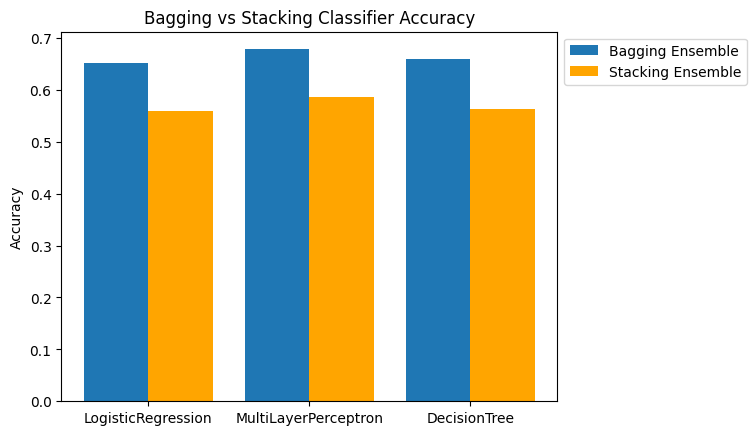

In [11]:
import matplotlib.pyplot as plt

base_estimator_models=['LogisticRegression','MultiLayerPerceptron','DecisionTree']
bagging_ensemble_accuracy = [0.652,0.678,0.660]
stacking_ensemble_accuracy = [best_accuracy_lg,best_accuracy_mlp,best_accuracy_dt]

fig, ax = plt.subplots()
ax.bar(np.arange(3), bagging_ensemble_accuracy, width=0.4, label="Bagging Ensemble", align='center')
ax.bar(np.arange(3) + 0.4, stacking_ensemble_accuracy, width=0.4, label="Stacking Ensemble", align='center', color='orange')
ax.set_xticks(np.arange(3) + 0.2)
ax.set_xticklabels(base_estimator_models)
ax.set_ylabel('Accuracy')
ax.set_title('Bagging vs Stacking Classifier Accuracy')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


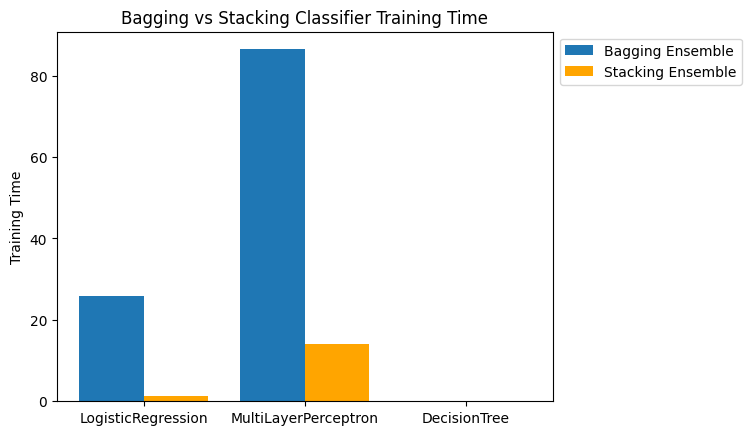

In [106]:
import matplotlib.pyplot as plt

base_estimator_models=['LogisticRegression','MultiLayerPerceptron','DecisionTree']
bagging_ensemble_training_time = [25.99,86.49,0.023]
stacking_ensemble_training_time = [training_time_cl_lg,training_time_cl_mlp,training_time_cl_dt]

fig, ax = plt.subplots()
ax.bar(np.arange(3), bagging_ensemble_training_time, width=0.4, label="Bagging Ensemble", align='center')
ax.bar(np.arange(3) + 0.4, stacking_ensemble_training_time, width=0.4, label="Stacking Ensemble", align='center', color='orange')
ax.set_xticks(np.arange(3) + 0.2)
ax.set_xticklabels(base_estimator_models)
ax.set_ylabel('Training Time')
ax.set_title('Bagging vs Stacking Classifier Training Time')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


In [12]:
import time
base_models = [MultipleLinearRegression(0.001,10000),MultipleLinearRegression(0.001,10000),MultipleLinearRegression(0.001,10000)]
best_r2_lg = 0
training_time_reg_lg = 0
meta_model = MultipleLinearRegression(0.001,10000)
stacking_model = StackingRegressor(base_models, meta_model)
start=time.time()
r2=stacking_model.stacking(X_train_reg, y_train_reg)
end=time.time()
if(r2>best_r2_lg):
    best_r2_lg=r2
    training_time_reg_lg=end-start

meta_model = MultipleLinearRegression(0.001,10000)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.blending(X_train_reg, y_train_reg)
if(r2>best_r2_lg):
    best_r2_lg=r2
    training_time_reg_lg=end-start

meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.stacking(X_train_reg, y_train_reg)
if(r2>best_r2_lg):
    best_r2_lg=r2
    training_time_reg_lg=end-start

meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.blending(X_train_reg, y_train_reg)
if(r2>best_r2_reg):
    best_r2_lg=r2
    training_time_reg_lg=end-start

In [13]:
import time
base_models = [DecisionTreeRegressor(criterion='squared_error',max_depth=20),DecisionTreeRegressor(criterion='squared_error',max_depth=20),DecisionTreeRegressor(criterion='squared_error',max_depth=20)]
best_r2_dt = 0
training_time_reg_dt = 0
meta_model = MultipleLinearRegression(0.001,10000)
stacking_model = StackingRegressor(base_models, meta_model)
start=time.time()
r2=stacking_model.stacking(X_train_reg, y_train_reg)
end=time.time()
if(r2>best_r2_dt):
    best_r2_dt=r2
    training_time_reg_dt=end-start

meta_model = MultipleLinearRegression(0.001,10000)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.blending(X_train_reg, y_train_reg)
if(r2>best_r2_dt):
    best_r2_dt=r2
    training_time_reg_dt=end-start

meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.stacking(X_train_reg, y_train_reg)
if(r2>best_r2_dt):
    best_r2_dt=r2
    training_time_reg_dt=end-start

meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.blending(X_train_reg, y_train_reg)
if(r2>best_r2_dt):
    best_r2_dt=r2
    training_time_reg_dt=end-start

In [14]:
import time
base_models = [MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd"),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd"),MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")]
best_r2_mlp = 0
training_time_reg_mlp = 0
meta_model = MultipleLinearRegression(0.001,10000)
stacking_model = StackingRegressor(base_models, meta_model)
start=time.time()
r2=stacking_model.stacking(X_train_reg, y_train_reg)
end=time.time()
if(r2>best_r2_mlp):
    best_r2_mlp=r2
    training_time_reg_mlp=end-start

meta_model = MultipleLinearRegression(0.001,10000)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.blending(X_train_reg, y_train_reg)
if(r2>best_r2_mlp):
    best_r2_mlp=r2
    training_time_reg_mlp=end-start

meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.stacking(X_train_reg, y_train_reg)
if(r2>best_r2_mlp):
    best_r2_mlp=r2
    training_time_reg_mlp=end-start

meta_model = DecisionTreeRegressor(criterion='squared_error',max_depth=20)
stacking_model = StackingRegressor(base_models, meta_model)
r2=stacking_model.blending(X_train_reg, y_train_reg)
if(r2>best_r2_mlp):
    best_r2_mlp=r2
    training_time_reg_mlp=end-start

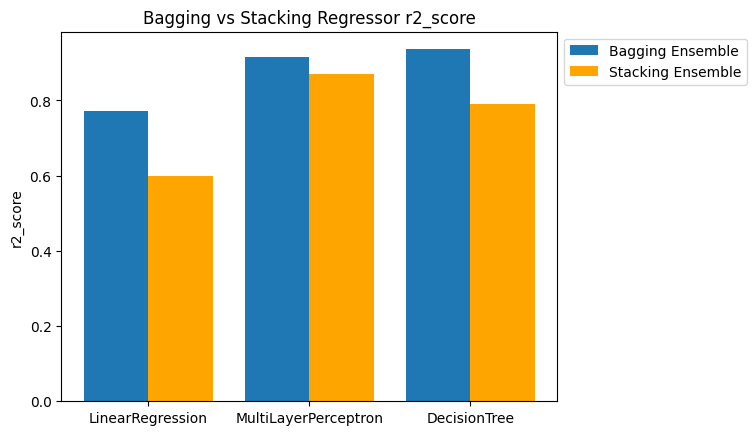

In [15]:
import matplotlib.pyplot as plt

base_estimator_models=['LinearRegression','MultiLayerPerceptron','DecisionTree']
bagging_ensemble_r2 = [0.773,0.916,0.936]
stacking_ensemble_r2 = [best_r2_lg,best_r2_mlp,best_r2_dt]

fig, ax = plt.subplots()
ax.bar(np.arange(3), bagging_ensemble_r2, width=0.4, label="Bagging Ensemble", align='center')
ax.bar(np.arange(3) + 0.4, stacking_ensemble_r2, width=0.4, label="Stacking Ensemble", align='center', color='orange')
ax.set_xticks(np.arange(3) + 0.2)
ax.set_xticklabels(base_estimator_models)
ax.set_ylabel('r2_score')
ax.set_title('Bagging vs Stacking Regressor r2_score')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


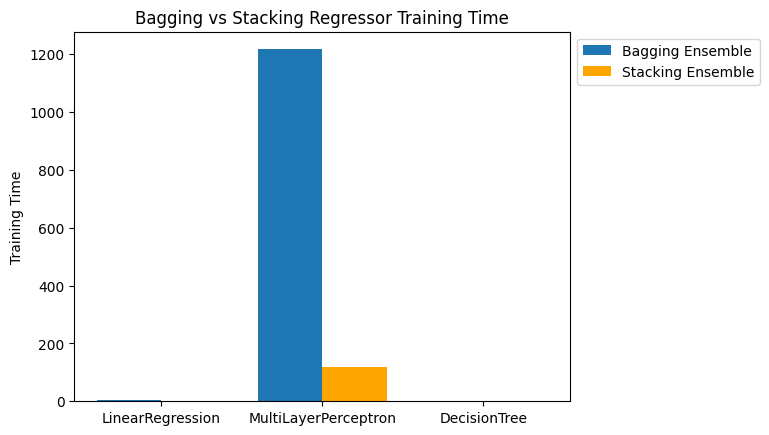

In [16]:
import matplotlib.pyplot as plt

base_estimator_models=['LinearRegression','MultiLayerPerceptron','DecisionTree']
bagging_ensemble_training_time = [4.10,1216.16,0.298]
stacking_ensemble_training_time = [training_time_reg_lg,training_time_reg_mlp,training_time_reg_dt]

fig, ax = plt.subplots()
ax.bar(np.arange(3), bagging_ensemble_training_time, width=0.4, label="Bagging Ensemble", align='center')
ax.bar(np.arange(3) + 0.4, stacking_ensemble_training_time, width=0.4, label="Stacking Ensemble", align='center', color='orange')
ax.set_xticks(np.arange(3) + 0.2)
ax.set_xticklabels(base_estimator_models)
ax.set_ylabel('Training Time')
ax.set_title('Bagging vs Stacking Regressor Training Time')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()
